(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Import project package
import Antibiotic

# Load CairoMakie for plotting
using CairoMakie
import PairPlots
import ColorSchemes

# Import basic math libraries
import StatsBase
import LinearAlgebra
import Random
import Distributions

# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.theme_makie!()

# Evolutionary dynamics on a fitness and mutational landscape

In this notebook we will explore a simple model of evolution on a fitness
landscape with an explicit mutational landscape.

The setting is the following:

Let $\underline{x}(t) = (x_1(t), x_2(t), \cdots, x_N(t))$ be an $N$ dimensional
vector of phenotypes at time $t$. The fitness for a given environment $E$ is
a scalar function $F_E(\underline{x})$ such that
$$
F_E: \mathbb{R}^N \to \mathbb{R},
\tag{1}
$$
i.e, the coordinates in phenotype space map to a fitness value. As a particular
fitness function we will consider a series of Gaussian fitness peaks, i.e.,
$$
F_E(\underline{x}) = \sum_{p=1}^P A_p \exp\left(-\frac{1}{2}(\underline{x} - \underline{\hat{x}}^{(p)})^T \Sigma_p^{-1} (\underline{x} - \underline{\hat{x}}^{(p)})\right),
\tag{2}
$$
where $P$ is the number of peaks, $A_p$ is the amplitude of the $p$-th peak,
$\underline{\hat{x}}^{(p)}$ is the $N$-dimensional vector of optimal phenotypes for the
$p$-th peak, and $\Sigma_p$ is the $N \times N$ covariance matrix for the $p$-th peak.
This formulation allows for multiple peaks in the fitness landscape, each potentially
having different heights, widths, and covariance structures between dimensions.
The covariance matrix $\Sigma_p$ captures potential interactions between different
phenotypic dimensions, allowing for more complex and realistic fitness landscapes.

In the same vein, we define a mutational landscape $M(\underline{x})$ as a scalar
function that maps a phenotype to a mutational effect, i.e.,
$$
M: \mathbb{R}^N \to \mathbb{R},
\tag{3}
$$
where $M(\underline{x})$ is related to the probability of a genotype mapping to
a phenotype $\underline{x}$. As a particular mutational landscape we will
consider a set of negative Gaussian peaks that will serve as "mutational
barriers" that limit the range of phenotypes that can be reached. The deeper the
peak, the more difficult it is to reach the phenotype associated with that peak.
This idea is captured by the following mutational landscape:
$$
M(\underline{x}) = \sum_{p=1}^P -B_p \exp\left(-\frac{1}{2}(\underline{x} - \underline{\hat{x}}^{(p)})^T \Sigma_p^{-1} (\underline{x} - \underline{\hat{x}}^{(p)})\right),
\tag{4}
$$
where $B_p$ is the depth of the $p$-th peak, and $\underline{\hat{x}}^{(p)}$ is the $N$-dimensional vector of optimal phenotypes for the $p$-th peak.

Both, the fitness landscape and the mutational landscape are built on Gaussian
functions. Let's therefore define a `struct` to hold the parameters of a single
peak.

In [2]:
@doc raw"""
    GaussianPeak

A struct to hold the parameters of a single Gaussian peak.

# Fields
- `amplitude::AbstractFloat`: The amplitude of the peak.
- `mean::AbstractVector`: The mean of the peak.
- `covariance::AbstractVecOrMat`: The covariance matrix of the peak. If the
  covariance matrix is diagonal, it can be passed as a vector.
"""
struct GaussianPeak
    amplitude::AbstractFloat
    mean::AbstractVector
    covariance::AbstractVecOrMat
end

GaussianPeak

Next, let's define a function to evaluate the fitness landscape at a given
phenotype.

In [3]:
@doc raw"""
    fitness(peak::Union{GaussianPeak, Vector{GaussianPeak}}, x::AbstractVecOrMat)

Calculate the fitness value for a given phenotype `x` based on Gaussian peak(s).

The first method computes the fitness for a single Gaussian peak, while the
second method computes the sum of fitness values for multiple Gaussian peaks.

# Arguments
- `peak::Union{GaussianPeak, Vector{GaussianPeak}}`: A single Gaussian peak or a
  vector of Gaussian peaks.
- `x::AbstractVecOrMat`: The phenotype(s) for which to calculate the fitness.
  Can be a vector for a single phenotype or a matrix for multiple phenotypes,
  where each column corresponds to a phenotype.

# Returns
The calculated fitness value(s).
"""
function fitness(peak::GaussianPeak, x::AbstractVecOrMat)
    return peak.amplitude *
           exp(-0.5 * (x - peak.mean)' * inv(peak.covariance) * (x - peak.mean)
    )
end

function fitness(peak::Vector{GaussianPeak}, x::AbstractVecOrMat)
    return sum(fitness(peak, x) for peak in peaks)
end

fitness (generic function with 2 methods)

Let's test the fitness function with a single Gaussian peak.

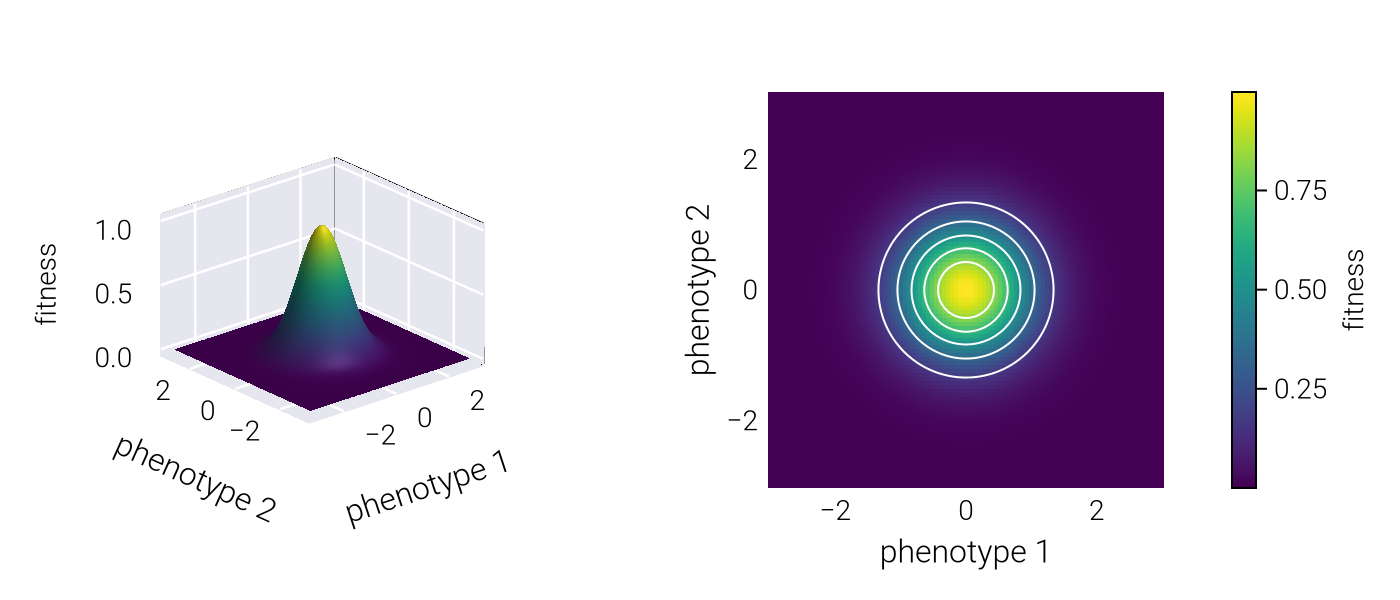

In [16]:
# Define peak parameters
amplitude = 1.0
mean = [0.0, 0.0]
covariance = [0.5 0.0; 0.0 0.5]

# Create peak
fit_peak = GaussianPeak(amplitude, mean, covariance)

# Define range of phenotypes to evaluate
x = range(-3, 3, length=100)
y = range(-3, 3, length=100)

# Create meshgrid
F = fitness.(Ref(fit_peak), [[x, y] for x in x, y in y])

# Initialize figure
fig = Figure(size=(700, 300))

# Add axis for 3D plot
ax3 = Axis3(
    fig[1, 1],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    zlabel="fitness",
)

# Add axis for contour plot
ax2 = Axis(
    fig[1, 2],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    aspect=AxisAspect(1),
)

# Plot fitness landscape
surface!(ax3, x, y, F, color=F, colormap=:viridis)

# Plot a heatmap of the fitness landscape
hm = heatmap!(ax2, x, y, F)

# Add a colorbar
Colorbar(fig[1, 3], hm, label="fitness")

# Plot contour plot
contour!(ax2, x, y, F, color=:white)

fig

Next, let's define a function to evaluate the mutational landscape at a given
phenotype.

In [5]:
@doc raw"""
    mutational_landscape(peak::GaussianPeak, x::AbstractVecOrMat)

Calculate the mutational landscape value for a given phenotype `x` based on
Gaussian peak(s).

# Arguments
- `peak::Union{GaussianPeak, Vector{GaussianPeak}}`: A single Gaussian peak or a
  vector of Gaussian peaks.
- `x::AbstractVecOrMat`: The phenotype(s) for which to calculate the mutational
  landscape. Can be a vector for a single phenotype or a matrix for multiple
  phenotypes, where each column corresponds to a phenotype.

# Returns
The calculated mutational landscape value(s).
"""
function mutational_landscape(peak::GaussianPeak, x::AbstractVecOrMat)
    return -peak.amplitude *
           exp(-0.5 * (x - peak.mean)' * inv(peak.covariance) * (x - peak.mean)
    )
end

function mutational_landscape(peak::Vector{GaussianPeak}, x::AbstractVecOrMat)
    return sum(mutational_landscape(peak, x) for peak in peaks)
end

mutational_landscape (generic function with 2 methods)

Let's test the mutational landscape function with four Gaussian peaks in the 
corners of a square in phenotype space.

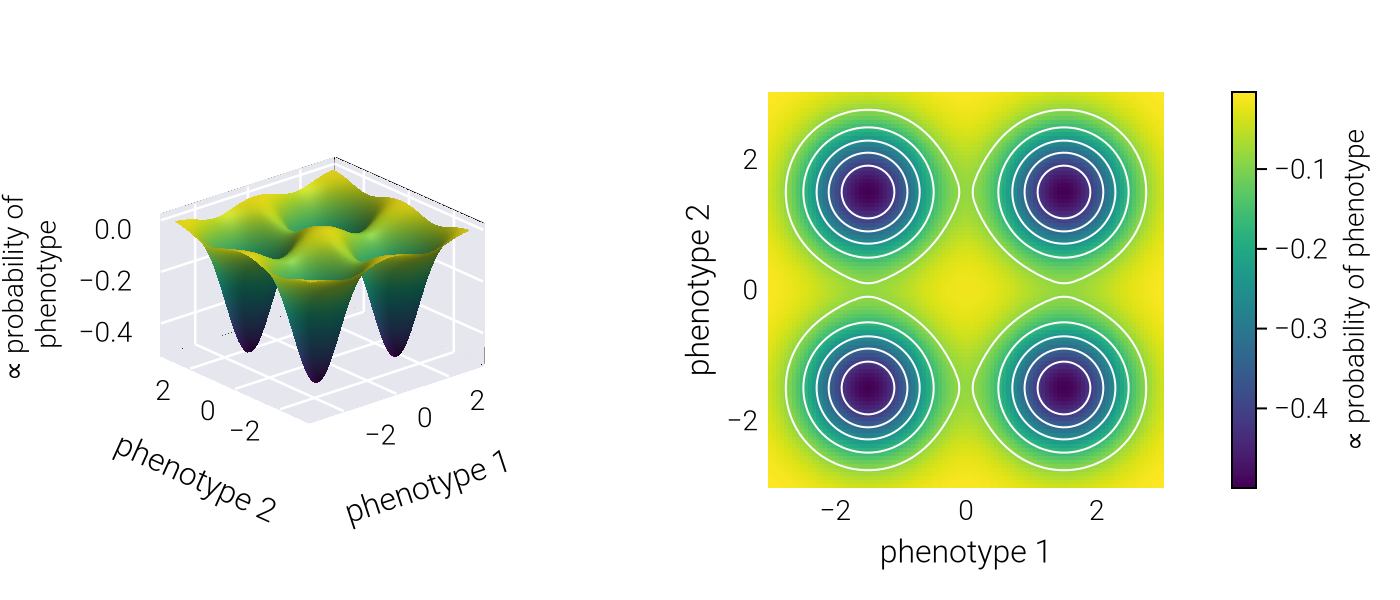

In [15]:
# Define peak parameters
amplitude = 0.5
means = [
    [-1.5, -1.5],
    [1.5, -1.5],
    [1.5, 1.5],
    [-1.5, 1.5],
]
covariance = [0.45 0.0; 0.0 0.45]

# Create peak
mut_peaks = GaussianPeak.(Ref(amplitude), means, Ref(covariance))

# Define range of phenotypes to evaluate
x = range(-3, 3, length=100)
y = range(-3, 3, length=100)

# Create meshgrid
M = mutational_landscape.(Ref(mut_peaks), [[x, y] for x in x, y in y])

# Initialize figure
fig = Figure(size=(700, 300))

# Add axis for 3D plot
ax3 = Axis3(
    fig[1, 1],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    zlabel="∝ probability of \nphenotype",
)

# Add axis for contour plot
ax2 = Axis(
    fig[1, 2],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    aspect=AxisAspect(1),
)

# Plot mutational landscape
surface!(ax3, x, y, M, color=M, colormap=:viridis)

# Plot a heatmap of the mutational landscape
hm = heatmap!(ax2, x, y, M)

# Add a colorbar
Colorbar(fig[1, 3], hm, label="∝ probability of phenotype")

# Plot contour plot
contour!(ax2, x, y, M, color=:white)

fig

## Evolutionary dynamics

Having defined the fitness and mutational landscapes, we can now explore the
evolutionary dynamics of a population of phenotypes. We will use a simple
genetic algorithm to evolve a population of phenotypes.

Let's consider a population defined on a two-dimensional phenotype space with
dominant phenotype $\underline{x}(t)$. We model the population dynamics as a
stochastic process of the form
$$
\frac{d\underline{x}(t)}{dt} = \mu(\underline{x}(t)) + 
\sigma(\underline{x}(t))  d\underline{W}(t),
\tag{5}
$$
where $\underline{W}(t)$ is a standard Wiener process. We can argue that the
drift term can be expressed as
$$
\mu(\underline{x}(t)) = \nabla \ln F_E(\underline{x}(t)) + 
\nabla \ln M(\underline{x}(t)),
\tag{6}
$$

